# **Ejercicio 3: Modelos de Regresión**

**Modelos de Regresión.** Considere el conjunto de datos **Wind Speed**. Implemente la versión de regresión de cada uno de los modelos estudiados en clases, para predecir la velocidad del viento horaria (**VENTO, VELOCIDADE HORARIA (m/s)**) en el conjunto de datos suministrado. Construya una tabla de error con las métricas usuales de regresión: **MAPE, RMSE, R2** (ver **Table 2**). Además, agregue pruebas de independencia y normalidad para los residuos: **Ljung-Box p-value** y **Jarque-Bera p-value**. Realice particiones de entrenamiento, validación y prueba, basándose en lo descrito en la **Figura 2**. Estas particiones deben seguir la tendencia de la velocidad del viento. Genere una figura que represente la velocidad del viento y su predicción. Utilice las métricas **MAPE, RMSE, R2** en la fase de validación para seleccionar la mejor predicción. Identifique cuál de las métricas es la más adecuada. Use también la optimización bayesiana para seleccionar los mejores hiperparámetros del modelo de regresión óptimo. 

El pliegue de validación en cada partición debe estar siempre ubicado en el porcentaje final de cada partición, ya que el tiempo es fundamental en dichas predicciones. No tiene sentido predecir el pasado conocido con el futuro. Entre los períodos diarios **T = 7, 14, 21, 28**, indique cuál corresponde a la mejor ventana de predicción para el entrenamiento. Tenga en cuenta que **TimeSeriesSplit** no aplica en este problema, por lo que no debe utilizarla, dado que dichos pliegues no corresponden a los solicitados en este ejercicio. Defina una función para construir los pliegues para este ejercicio.

| Modelo                 | MAPE | RMSE | R²   | Ljung-Box p-value | Jarque-Bera p-value |
|-----------------------|------|------|------|--------------------|----------------------|
| K-NN                  | ...  | ...  | ...  | ...                | ...                  |
| Linear Regression      | ...  | ...  | ...  | ...                | ...                  |
| Ridge Regression       | ...  | ...  | ...  | ...                | ...                  |
| Lasso Regression       | ...  | ...  | ...  | ...                | ...                  |

**Cuadro 2:** Modelo de regresión para **mean sale price**.


## **Librerías y modulos necesarios**

In [65]:
import warnings
import numpy as np
from scipy.stats import jarque_bera
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.linear_model import Ridge
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings("ignore")

# **Modelo de regresión: Wind Speed**

## **Datos**

Después de haber realizado un análisis descriptivo de la base de datos original (detallado [Wind Speed - Ejercicio 1](https://kmarcela11.github.io/Parcial2_MachineLearning/Ejercicio1.html#wind-speed)
), finalmente se ha obtenido una base de datos preparada para realizar el modelo, la cual ha sido almacenada en un archivo CSV.

### **Diferencias entre la base de datos original y la del modelo**

- La nueva base de datos presenta nombres de columnas más legibles y mejor organizados.
- Se han eliminado variables poco significativas para el modelo, como:
  - La variable de **hora**.
- Se han excluido variables altamente correlacionadas, tales como:
  - `hum_horaria`
  - `pres_atmo`


In [2]:
data = pd.read_csv('C:\\Users\\kamac\\OneDrive\\Desktop\\MachineLearningUN\\data_modelo.csv')

In [3]:
data

,dir_viento,vel_viento,hum_max,hum_min,temp_max,temp_min,precip_total,rafaga_max,pres_max,pres_min
0,0.809017,1.8,69.0,60.0,22.6,20.7,0.0,3.8,888.2,887.7
1,0.965926,2.7,62.0,55.0,24.2,22.5,0.0,4.7,888.4,888.2
2,0.891007,2.0,56.0,50.0,25.5,24.3,0.0,4.9,888.4,888.1
3,0.848048,2.5,52.0,44.0,27.4,25.0,0.0,5.8,888.1,887.4
4,0.224951,2.4,50.0,43.0,27.1,25.5,0.0,5.8,887.4,886.5
...,...,...,...,...,...,...,...,...,...,...
87688,-0.615661,5.6,83.0,78.0,21.8,21.1,0.0,12.3,879.8,879.1
87689,-0.469472,4.9,84.0,79.0,21.7,21.0,0.0,9.9,879.2,878.9
87690,-0.484810,4.5,86.0,82.0,21.2,20.6,0.0,8.9,879.8,879.2
87691,-0.484810,3.2,88.0,85.0,20.6,20.2,0.0,8.0,880.5,879.6


Nótese que la base de datos actual cuenta con **87693** observaciones y **10** columnas

Ahora, se asignan las variables predictoras y la variable objetivo, que en nuestro caso es la velocidad del viento (`vel_viento`).

In [4]:
X = data.drop(columns = ['vel_viento'])
y = data['vel_viento']

In [5]:
def MAPEP(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitar la división por cero, ignorando los valores donde y_true es 0
    non_zero_indices = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape




  ## **Modelos**

El objetivo de este trabajo es realizar pruebas con datos para 24 horas, aplicando 4 modelos de regresión a cada una de esas horas (**KNN Regressor**, **Linear Regression**, **Ridge** y **Lasso**), lo que resultará en un total de **96 modelos**. Estos modelos serán representados en **24 tablas**, una para cada hora, y adicionalmente se agruparán en **4 tablas por modelo**, es decir, una tabla para **KNN**, una para **Ridge**, una para **Lasso** y otra para **Linear Regression**. En cada tabla, se analizará cómo varía la construcción de los pliegues y cómo estos afectan el rendimiento de los modelos.

Para la validación de los modelos, se utilizarán las métricas **RMSE**, **MAPE** y **$R^2$**. El propósito es seleccionar, de cada una de las cuatro tablas por modelo de regresión, el modelo con el menor **RMSE**. Estos se agruparán en una tabla que contendrá los **4 mejores modelos** obtenidos. Finalmente, de esos cuatro, el mejor será aquel que presente el menor **RMSE**, que, a su vez, será equivalente al que tenga el mejor **$R^2$**.

Se utiliza **RMSE** como métrica principal porque, al calcular la **raíz cuadrada del promedio de los errores al cuadrado**, penaliza más los errores grandes, proporcionando una evaluación más precisa del rendimiento del modelo en comparación con otras métricas como el MAPE o el MSE. Además, el **RMSE** es equivalente con el **$R^2$**, dado que a menor **RMSE** mayor coeficiente de determinación (**$R^2$**)

A continuación, se define un diccionario que contiene los modelos junto con los hiperparámetros óptimos obtenidos tras la optimización bayesiana. Estos valores ajustados permitirán evaluar y comparar el rendimiento de cada modelo de manera eficiente.

In [7]:
# Definir los modelos
modelos = {
    'Regresión K-NN': KNeighborsRegressor(),
    'Regresión Lineal': LinearRegression(),
    'Regresión Ridge': Ridge(),
    'Regresión Lasso': Lasso()
}

Ahora se crea un código que define la función **`entrenar_y_evaluar`**, la cual entrena y evalúa múltiples modelos de regresión utilizando conjuntos de datos de entrenamiento y prueba. A cada modelo se le aplica una serie de métricas para medir su rendimiento, como **RMSE** (Root Mean Squared Error), **MAPE** (Mean Absolute Percentage Error) y **$R^2$** (coeficiente de determinación). Estos modelos se evalúan para una hora específica y una ventana de predicción representada por `k`. Los resultados obtenidos, que incluyen el nombre del modelo, la hora de predicción, la ventana de predicción y las métricas calculadas, se almacenan en una lista llamada **`resultados`**. De esta forma, se recopilan y organizan los resultados de las pruebas realizadas para su análisis posterior.


In [8]:
resultados = []
def entrenar_y_evaluar(X_train, y_train, X_test, y_test, modelos, k, hora):
    for nombre, modelo in modelos.items(): 
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        RMSE = mean_squared_error(y_test, y_pred, squared = False)
        MAPE = MAPEP(y_test, y_pred)
        R2 = r2_score(y_test, y_pred)
        resultados.append({ 
            'Modelo': nombre,
            'Hora': hora,
            'Ventana de predicción': k,
            'MAPE': MAPE,
            'RMSE': RMSE,
            'R^2': R2
        })

#### **Función para construir los pliegues**

En esta sección, se definen dos funciones importantes para generar los pliegues de entrenamiento y prueba en función de distintas ventanas de predicción (7, 14, 21 y 28 días).

1. La primera función, **`pliegues`**, recibe los parámetros `train_inicial`, `train_final` y `hora`, y se encarga de calcular los índices para seleccionar los subconjuntos de datos de entrenamiento (`X_train`, `y_train`) y prueba (`X_test`, `y_test`) mediante filtrado booleano sobre los índices del DataFrame. Devuelve estos subconjuntos para ser utilizados posteriormente.

2. La segunda función, **`pliegues_modelo_hora`**, toma los datos `X`, `y`, los modelos a evaluar, y la hora específica. Recorre cada uno de los períodos definidos en la lista `periodos` (7, 14, 21 y 28 días), y para cada ventana de predicción, calcula los índices de entrenamiento y prueba. Llama a la función **`pliegues`** para obtener los subconjuntos correspondientes y, posteriormente, los pasa a la función **`entrenar_y_evaluar`**, que se encarga de entrenar y evaluar los modelos en cada ventana de predicción. Además, la función actualiza `train_inicial` para avanzar a la siguiente ventana dentro del ciclo, lo que permite que el modelo recorra el conjunto de datos completo.


In [78]:
def pliegues(train_inicial, train_final, hora):
# Filtrado booleano para X_train y y_train
    entrenamiento_indices = (X.index >= train_inicial) & (X.index < train_final) # Se seleccionan los datos de entrenamiento
    X_train = X[entrenamiento_indices]
    y_train = y[entrenamiento_indices] 

    # Filtrado booleano para X_test y y_test
    test_indices = (X.index >= (train_final + hora)) & (X.index < (train_final + hora + 24)) # Se seleccionan los datos de prueba
    X_test = X[test_indices]
    y_test = y[test_indices]
    return X_train, y_train, X_test, y_test

In [10]:
periodos = [7, 14, 21, 28]  # Vector que almacena el valor de los períodos díarios a tener en cuenta (ventanas de predicción)

def pliegues_modelo_hora(X,modelos, hora):
    for k in periodos:  # Ciclo que recorre vector de periodos para que el proceso se realice para cada una de las ventanas de predicción (7, 14, 21, 28)
        train_inicial = 0  # Se inicializa el índice de inicio de la ventana de entrenamiento
        
        while (train_inicial + (k * 24) + hora) < len(X):  # Ciclo que se ejecuta mientras la ventana de entrenamiento no sobrepase el tamaño del dataset
            
            train_final = train_inicial + (k * 24)  # Se calcula el índice final de la ventana de entrenamiento
            
            X_train, y_train, X_test, y_test = pliegues(train_inicial, train_final, hora)  # Se obtienen los conjuntos de entrenamiento y prueba
            
            entrenar_y_evaluar(X_train, y_train, X_test, y_test, modelos,k, hora)
            train_inicial = train_final  # Se actualiza para avanzar a la siguiente ventana.

### **Modelos individuales por horas (24 horas)**

Ahora, veamos lo anteriormente mencionado: los modelos individuales para cada una de las 24 horas, donde se aplican los cuatro modelos (**KNN**, **Ridge**, **Lasso** y **Linear Regression**).

- Para realizar esto:  Se ejecuta la función **`pliegues_modelo_hora`** para cada una de las 24 horas y se almacenan los resultados en el DataFrame **`hora{i}`**, donde **i = 1,...,24**. Luego, este DataFrame se agrupa por **modelo**, **ventana de predicción** y **hora**, utilizando el método **`groupby`** para calcular el promedio de las métricas de rendimiento. Finalmente, se genera **`hora{i}_mean`**, que contiene los valores medios de las métricas para cada modelo y ventana de predicción, lo que facilita el análisis comparativo de los resultados y permite identificar el mejor modelo según las métricas calculadas para cada hora específica.

- Para comprender esto: Los resultados se presentan en una tabla con **6 columnas y 16 filas**, donde cada conjunto de 4 filas corresponde a uno de los 4 modelos aplicados  (**KNN**, **Ridge**, **Lasso** y **Linear Regression**) en las diferentes ventanas de predicción (7, 14, 21 y 28 días). Las columnas incluyen el **modelo**, la **ventana de predicción**, la **hora**, y las métricas de rendimiento: **MAPE**, **RMSE** y **R²**. Es importante destacar que la columna de la hora no varía dentro de cada tabla, ya que cada tabla es específica para una hora en particular. Las métricas permiten observar el comportamiento de los modelos en función de las ventanas de predicción, facilitando la comparación entre ellos. 



**Nota:** Dado la cantidad de tablas generadas, las interpretaciones se encuentran de manera general al final, cuando se terminan las tablas.

#### **Pronóstico de la hora 1**

In [11]:
hora1 = pliegues_modelo_hora(X,modelos, 1) 
hora1 = pd.DataFrame(resultados)
hora1_min_rmse = hora1.loc[hora1.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop = True)
hora1_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,1,7,14.197404,0.442003,0.739650
1,Regresión K-NN,1,14,14.121390,0.487220,0.743249
2,Regresión K-NN,1,21,22.808862,0.438482,0.588184
3,Regresión K-NN,1,28,9.585378,0.399166,0.803793
4,Regresión Lasso,1,7,16.526000,0.368618,0.432809
5,Regresión Lasso,1,14,14.921524,0.423962,0.481896
6,Regresión Lasso,1,21,26.271589,0.395329,0.888162
7,Regresión Lasso,1,28,14.907412,0.418688,0.494708
8,Regresión Lineal,1,7,34.968712,0.294249,0.852346
9,Regresión Lineal,1,14,17.518588,0.343691,0.506927


#### **Pronóstico de la hora 2**

In [12]:
resultados = []
hora2 = pliegues_modelo_hora(X,modelos, 2) 
hora2 = pd.DataFrame(resultados)
hora2_min_rmse = hora2.loc[hora1.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop = True)
hora2_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,2,7,15.437170,0.457566,0.730520
1,Regresión K-NN,2,14,14.770741,0.494014,0.736038
2,Regresión K-NN,2,21,24.201313,0.514312,0.445958
3,Regresión K-NN,2,28,9.850530,0.403753,0.749500
4,Regresión Lasso,2,7,16.685253,0.374123,0.421321
5,Regresión Lasso,2,14,16.495490,0.472811,0.387068
6,Regresión Lasso,2,21,25.515211,0.389335,0.889422
7,Regresión Lasso,2,28,16.458948,0.463941,0.409849
8,Regresión Lineal,2,7,35.154450,0.311646,0.842928
9,Regresión Lineal,2,14,17.367080,0.343398,0.512465


#### **Pronóstico de la hora 3**

In [13]:
resultados = []
hora3 = pliegues_modelo_hora(X, modelos, 3)
hora3 = pd.DataFrame(resultados)
hora3_min_rmse = hora3.loc[hora3.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora3_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,3,7,16.989267,0.444503,0.782061
1,Regresión K-NN,3,14,10.401227,0.483425,0.716291
2,Regresión K-NN,3,21,19.526820,0.413199,0.854273
3,Regresión K-NN,3,28,12.129570,0.432762,0.755629
4,Regresión Lasso,3,7,15.502170,0.318170,0.913595
5,Regresión Lasso,3,14,24.095939,0.451624,0.251506
6,Regresión Lasso,3,21,9.658325,0.311801,0.917019
7,Regresión Lasso,3,28,10.991575,0.456726,0.597868
8,Regresión Lineal,3,7,34.193844,0.310303,0.835795
9,Regresión Lineal,3,14,10.414414,0.330499,0.852527


#### **Pronóstico de la hora 4**

In [14]:
resultados = []
hora4 = pliegues_modelo_hora(X, modelos, 4)
hora4 = pd.DataFrame(resultados)
hora4_min_rmse = hora4.loc[hora4.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora4_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,4,7,13.595712,0.432493,0.745294
1,Regresión K-NN,4,14,10.448847,0.481196,0.724071
2,Regresión K-NN,4,21,18.262616,0.402906,0.854985
3,Regresión K-NN,4,28,15.046237,0.434166,0.805614
4,Regresión Lasso,4,7,14.936429,0.319067,0.909057
5,Regresión Lasso,4,14,19.711060,0.430070,0.694667
6,Regresión Lasso,4,21,9.624911,0.317652,0.909862
7,Regresión Lasso,4,28,24.431823,0.456057,0.518794
8,Regresión Lineal,4,7,13.549728,0.327209,0.880260
9,Regresión Lineal,4,14,10.423193,0.330925,0.845664


#### **Pronóstico de la hora 5**

In [15]:
resultados = []
hora5 = pliegues_modelo_hora(X, modelos, 5)
hora5 = pd.DataFrame(resultados)
hora5_min_rmse = hora5.loc[hora5.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
display(hora5_min_rmse)


,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,5,7,14.147091,0.438387,0.724461
1,Regresión K-NN,5,14,21.678255,0.468971,0.485452
2,Regresión K-NN,5,21,17.270552,0.394483,0.858206
3,Regresión K-NN,5,28,14.149539,0.402472,0.848079
4,Regresión Lasso,5,7,13.915467,0.305140,0.782162
5,Regresión Lasso,5,14,21.404801,0.415432,0.596229
6,Regresión Lasso,5,21,9.470311,0.317293,0.908268
7,Regresión Lasso,5,28,23.349564,0.426467,0.574495
8,Regresión Lineal,5,7,8.848311,0.336981,0.849481
9,Regresión Lineal,5,14,10.239251,0.330619,0.825295


#### **Pronóstico de la hora 6**

In [16]:
resultados = []
hora6 = pliegues_modelo_hora(X, modelos, 6)
hora6 = pd.DataFrame(resultados)
hora6_min_rmse = hora6.loc[hora6.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
display(hora6_min_rmse)

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,6,7,14.334712,0.441324,0.718410
1,Regresión K-NN,6,14,22.126171,0.474043,0.478729
2,Regresión K-NN,6,21,15.673330,0.385962,0.857199
3,Regresión K-NN,6,28,14.360695,0.404516,0.840520
4,Regresión Lasso,6,7,12.610870,0.300416,0.913486
5,Regresión Lasso,6,14,21.678055,0.419248,0.592273
6,Regresión Lasso,6,21,8.094454,0.309388,0.908241
7,Regresión Lasso,6,28,23.636164,0.430497,0.570100
8,Regresión Lineal,6,7,8.804746,0.336554,0.849862
9,Regresión Lineal,6,14,9.304360,0.324804,0.793134


#### **Pronóstico de la hora 7**

In [17]:
resultados = []
hora7 = pliegues_modelo_hora(X, modelos, 7)
hora7 = pd.DataFrame(resultados)
hora7_min_rmse = hora7.loc[hora7.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
display(hora7_min_rmse)

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,7,7,20.195250,0.436730,0.551216
1,Regresión K-NN,7,14,20.530777,0.453560,0.515961
2,Regresión K-NN,7,21,12.639364,0.381969,0.881616
3,Regresión K-NN,7,28,13.931040,0.372805,0.846283
4,Regresión Lasso,7,7,13.843998,0.307299,0.777806
5,Regresión Lasso,7,14,21.295631,0.415977,0.592855
6,Regresión Lasso,7,21,7.613160,0.402198,0.868745
7,Regresión Lasso,7,28,17.365585,0.422824,0.756157
8,Regresión Lineal,7,7,9.588294,0.325104,0.923284
9,Regresión Lineal,7,14,8.573194,0.305199,0.932390


#### **Pronóstico de la hora 8**

In [18]:
resultados = []
hora8 = pliegues_modelo_hora(X, modelos, 8)
hora8 = pd.DataFrame(resultados)
hora8_min_rmse = hora8.loc[hora8.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
display(hora8_min_rmse)


,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,8,7,21.644830,0.449370,0.536950
1,Regresión K-NN,8,14,21.980356,0.465743,0.502592
2,Regresión K-NN,8,21,13.221254,0.396884,0.867939
3,Regresión K-NN,8,28,14.543433,0.393510,0.794901
4,Regresión Lasso,8,7,15.184648,0.323291,0.760334
5,Regresión Lasso,8,14,15.425844,0.432181,0.380695
6,Regresión Lasso,8,21,8.400677,0.410048,0.859033
7,Regresión Lasso,8,28,16.812397,0.418663,0.763398
8,Regresión Lineal,8,7,9.913272,0.329544,0.918444
9,Regresión Lineal,8,14,8.911726,0.310895,0.927414


#### **Pronóstico de la hora 9**

In [19]:
resultados = []
hora9 = pliegues_modelo_hora(X, modelos, 9)
hora9 = pd.DataFrame(resultados)
hora9_min_rmse = hora9.loc[hora9.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
display(hora9_min_rmse)


,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,9,7,21.276409,0.445271,0.554856
1,Regresión K-NN,9,14,21.611935,0.461790,0.521216
2,Regresión K-NN,9,21,13.279225,0.405668,0.857086
3,Regresión K-NN,9,28,14.403880,0.390790,0.778471
4,Regresión Lasso,9,7,14.958624,0.321976,0.767246
5,Regresión Lasso,9,14,15.273920,0.436847,0.567308
6,Regresión Lasso,9,21,8.185879,0.409547,0.854340
7,Regresión Lasso,9,28,16.875555,0.423746,0.756062
8,Regresión Lineal,9,7,9.439085,0.320507,0.922856
9,Regresión Lineal,9,14,8.292432,0.304664,0.930294


#### **Pronóstico de la hora 10**

In [20]:
resultados = []
hora10 = pliegues_modelo_hora(X, modelos, 10)
hora10 = pd.DataFrame(resultados)
hora10_min_rmse = hora10.loc[hora10.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
display(hora10_min_rmse)

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,10,7,22.580330,0.458421,0.534562
1,Regresión K-NN,10,14,22.915857,0.474482,0.501377
2,Regresión K-NN,10,21,14.027643,0.436616,0.834112
3,Regresión K-NN,10,28,14.591160,0.404866,0.774033
4,Regresión Lasso,10,7,15.325772,0.323349,0.768434
5,Regresión Lasso,10,14,15.584906,0.425532,0.458121
6,Regresión Lasso,10,21,18.929521,0.448806,0.231845
7,Regresión Lasso,10,28,16.912574,0.424228,0.760285
8,Regresión Lineal,10,7,9.268959,0.319531,0.925632
9,Regresión Lineal,10,14,9.224217,0.307089,0.931310


#### **Pronóstico de la hora 11**

In [21]:
resultados = []
hora11 = pliegues_modelo_hora(X, modelos, 11)
hora11 = pd.DataFrame(resultados)
hora11_min_rmse = hora11.loc[hora11.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)

#### **Pronóstico de la hora 12**

In [22]:
resultados = []
hora12 = pliegues_modelo_hora(X, modelos, 12)
hora12 = pd.DataFrame(resultados)
hora12_min_rmse = hora12.loc[hora12.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora12_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,12,7,22.931658,0.471664,0.818106
1,Regresión K-NN,12,14,14.250504,0.495665,0.611983
2,Regresión K-NN,12,21,14.333990,0.485833,0.827711
3,Regresión K-NN,12,28,15.232860,0.428874,0.775648
4,Regresión Lasso,12,7,15.177607,0.323928,0.760466
5,Regresión Lasso,12,14,10.984037,0.411266,0.781241
6,Regresión Lasso,12,21,24.309155,0.452298,0.532996
7,Regresión Lasso,12,28,16.604959,0.410531,0.754634
8,Regresión Lineal,12,7,9.382491,0.324169,0.912348
9,Regresión Lineal,12,14,10.689670,0.330093,0.912710


#### **Pronóstico de la hora 13**

In [23]:
resultados = []
hora13 = pliegues_modelo_hora(X, modelos, 13)
hora13 = pd.DataFrame(resultados)
hora13_min_rmse = hora13.loc[hora13.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora13_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,13,7,22.961744,0.471363,0.807977
1,Regresión K-NN,13,14,33.690860,0.500350,0.456561
2,Regresión K-NN,13,21,34.807213,0.449963,0.740929
3,Regresión K-NN,13,28,15.464420,0.436730,0.774262
4,Regresión Lasso,13,7,17.125563,0.339163,0.756081
5,Regresión Lasso,13,14,15.329025,0.445802,0.843562
6,Regresión Lasso,13,21,32.132686,0.450928,0.558615
7,Regresión Lasso,13,28,28.571181,0.440404,0.617075
8,Regresión Lineal,13,7,9.681186,0.331589,0.897773
9,Regresión Lineal,13,14,11.367153,0.335554,0.874767


#### **Pronóstico de la hora 14**

In [24]:
resultados = []
hora14 = pliegues_modelo_hora(X, modelos, 14)
hora14 = pd.DataFrame(resultados)
hora14_min_rmse = hora14.loc[hora14.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora14_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,14,7,24.250259,0.488040,0.775284
1,Regresión K-NN,14,14,33.273127,0.498748,0.474298
2,Regresión K-NN,14,21,30.667001,0.422749,0.759011
3,Regresión K-NN,14,28,16.038779,0.453505,0.766656
4,Regresión Lasso,14,7,17.787283,0.341383,0.769785
5,Regresión Lasso,14,14,11.603499,0.452397,0.709240
6,Regresión Lasso,14,21,20.048753,0.439120,0.198819
7,Regresión Lasso,14,28,30.537625,0.454461,0.609237
8,Regresión Lineal,14,7,9.716426,0.320803,0.914474
9,Regresión Lineal,14,14,10.729919,0.325164,0.918944


#### **Pronóstico de la hora 15**

In [25]:
resultados = []
hora15 = pliegues_modelo_hora(X, modelos, 15)
hora15 = pd.DataFrame(resultados)
hora15_min_rmse = hora15.loc[hora15.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora15_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,15,7,23.893116,0.486655,0.783353
1,Regresión K-NN,15,14,28.464377,0.527194,0.569918
2,Regresión K-NN,15,21,30.681882,0.422847,0.760664
3,Regresión K-NN,15,28,15.862533,0.451959,0.768313
4,Regresión Lasso,15,7,18.259020,0.399856,0.752589
5,Regresión Lasso,15,14,11.308627,0.418011,0.717595
6,Regresión Lasso,15,21,29.969346,0.420054,0.688845
7,Regresión Lasso,15,28,15.861101,0.424505,0.755286
8,Regresión Lineal,15,7,9.734261,0.320850,0.913853
9,Regresión Lineal,15,14,11.400478,0.298717,0.820333


#### **Pronóstico de la hora 16**

In [26]:
resultados = []
hora16 = pliegues_modelo_hora(X, modelos, 16)
hora16 = pd.DataFrame(resultados)
hora16_min_rmse = hora16.loc[hora16.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora16_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,16,7,21.556284,0.482269,0.696128
1,Regresión K-NN,16,14,17.613207,0.482200,0.487958
2,Regresión K-NN,16,21,30.968657,0.424087,0.756954
3,Regresión K-NN,16,28,16.319961,0.480122,0.734253
4,Regresión Lasso,16,7,12.792681,0.426477,0.319667
5,Regresión Lasso,16,14,21.598331,0.391981,0.668929
6,Regresión Lasso,16,21,22.982435,0.410214,0.637413
7,Regresión Lasso,16,28,20.433908,0.375944,0.695464
8,Regresión Lineal,16,7,9.767949,0.321807,0.912484
9,Regresión Lineal,16,14,11.078443,0.294690,0.825242


#### **Pronóstico de la hora 17**

In [27]:
resultados = []
hora17 = pliegues_modelo_hora(X, modelos, 17)
hora17 = pd.DataFrame(resultados)
hora17_min_rmse = hora17.loc[hora17.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora17_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,17,7,21.556284,0.483356,0.694756
1,Regresión K-NN,17,14,17.780728,0.482200,0.325496
2,Regresión K-NN,17,21,26.936514,0.442418,0.658935
3,Regresión K-NN,17,28,27.490370,0.465976,0.621646
4,Regresión Lasso,17,7,18.686540,0.439007,0.638637
5,Regresión Lasso,17,14,20.109894,0.381775,0.667473
6,Regresión Lasso,17,21,21.396307,0.398646,0.637433
7,Regresión Lasso,17,28,19.000035,0.366928,0.692834
8,Regresión Lineal,17,7,9.821034,0.322261,0.911551
9,Regresión Lineal,17,14,11.425107,0.300634,0.811023


#### **Pronóstico de la hora 18**

In [28]:
resultados = []
hora18 = pliegues_modelo_hora(X, modelos, 18)
hora18 = pd.DataFrame(resultados)
hora18_min_rmse = hora18.loc[hora18.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora18_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,18,7,12.263832,0.505849,0.558980
1,Regresión K-NN,18,14,31.850106,0.472229,0.618248
2,Regresión K-NN,18,21,25.879966,0.417712,0.701304
3,Regresión K-NN,18,28,16.827036,0.449592,0.797582
4,Regresión Lasso,18,7,14.150000,0.443148,0.379818
5,Regresión Lasso,18,14,20.632178,0.385675,0.660966
6,Regresión Lasso,18,21,29.040652,0.399496,0.726787
7,Regresión Lasso,18,28,19.533081,0.372554,0.683642
8,Regresión Lineal,18,7,9.155890,0.318370,0.910779
9,Regresión Lineal,18,14,11.769794,0.310477,0.798818


#### **Pronóstico de la hora 19**

In [29]:
resultados = []
hora19 = pliegues_modelo_hora(X, modelos, 19)
hora19 = pd.DataFrame(resultados)
hora19_min_rmse = hora19.loc[hora19.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora19_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,19,7,11.985471,0.502278,0.573004
1,Regresión K-NN,19,14,32.619337,0.492138,0.585380
2,Regresión K-NN,19,21,26.585095,0.438064,0.671488
3,Regresión K-NN,19,28,26.949314,0.462133,0.634397
4,Regresión Lasso,19,7,13.806126,0.426039,0.347219
5,Regresión Lasso,19,14,13.900010,0.418930,0.368822
6,Regresión Lasso,19,21,29.704581,0.413583,0.707180
7,Regresión Lasso,19,28,20.070258,0.412628,0.653399
8,Regresión Lineal,19,7,9.244699,0.319080,0.907675
9,Regresión Lineal,19,14,12.479213,0.316882,0.803850


#### **Pronóstico de la hora 20**

In [30]:
resultados = []
hora20 = pliegues_modelo_hora(X, modelos, 20)
hora20 = pd.DataFrame(resultados)
hora20_min_rmse = hora20.loc[hora20.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora20_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,20,7,78.730551,0.478278,0.704514
1,Regresión K-NN,20,14,33.275902,0.493896,0.594840
2,Regresión K-NN,20,21,27.670953,0.443715,0.672987
3,Regresión K-NN,20,28,27.858404,0.467582,0.636862
4,Regresión Lasso,20,7,29.202370,0.420930,0.873416
5,Regresión Lasso,20,14,14.577646,0.426938,0.361331
6,Regresión Lasso,20,21,16.710045,0.412000,0.269045
7,Regresión Lasso,20,28,17.818840,0.428843,0.208060
8,Regresión Lineal,20,7,9.550341,0.320914,0.903901
9,Regresión Lineal,20,14,13.127729,0.318740,0.835023


#### **Pronóstico de la hora 21**

In [31]:
resultados = []
hora21 = pliegues_modelo_hora(X, modelos, 21)
hora21 = pd.DataFrame(resultados)
hora21_min_rmse = hora21.loc[hora21.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora21_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,21,7,11.386265,0.482459,0.596346
1,Regresión K-NN,21,14,32.937667,0.482424,0.630093
2,Regresión K-NN,21,21,26.680757,0.430116,0.705960
3,Regresión K-NN,21,28,27.456444,0.463843,0.658040
4,Regresión Lasso,21,7,18.907391,0.404422,0.603431
5,Regresión Lasso,21,14,31.979701,0.404536,0.881733
6,Regresión Lasso,21,21,14.453964,0.388631,0.186044
7,Regresión Lasso,21,28,15.112589,0.391008,0.176058
8,Regresión Lineal,21,7,20.061108,0.320673,0.934216
9,Regresión Lineal,21,14,12.505027,0.297012,0.855119


#### **Pronóstico de la hora 22**

In [32]:
resultados = []
hora22 = pliegues_modelo_hora(X, modelos, 22)
hora22 = pd.DataFrame(resultados)
hora22_min_rmse = hora22.loc[hora22.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora22_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,22,7,18.410448,0.491410,0.592242
1,Regresión K-NN,22,14,33.047621,0.500733,0.619611
2,Regresión K-NN,22,21,27.311544,0.456435,0.683936
3,Regresión K-NN,22,28,27.747725,0.475605,0.656830
4,Regresión Lasso,22,7,28.156628,0.411089,0.877318
5,Regresión Lasso,22,14,19.196821,0.407402,0.719740
6,Regresión Lasso,22,21,20.219205,0.417194,0.706105
7,Regresión Lasso,22,28,15.071364,0.432371,0.322895
8,Regresión Lineal,22,7,18.004313,0.309120,0.941401
9,Regresión Lineal,22,14,12.497507,0.296824,0.851230


#### **Pronóstico de la hora 23**

In [33]:
resultados = []
hora23 = pliegues_modelo_hora(X, modelos, 23)
hora23 = pd.DataFrame(resultados)
hora23_min_rmse = hora23.loc[hora23.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora23_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,23,7,19.703851,0.449815,0.685687
1,Regresión K-NN,23,14,26.359522,0.524627,0.740940
2,Regresión K-NN,23,21,15.496085,0.469982,0.587013
3,Regresión K-NN,23,28,23.946251,0.476760,0.786057
4,Regresión Lasso,23,7,25.203271,0.379640,0.891418
5,Regresión Lasso,23,14,31.139665,0.402607,0.877882
6,Regresión Lasso,23,21,23.146897,0.426096,0.717961
7,Regresión Lasso,23,28,15.416113,0.466937,0.387238
8,Regresión Lineal,23,7,18.344887,0.309440,0.942142
9,Regresión Lineal,23,14,13.323152,0.287042,0.872007


#### **Pronóstico de la hora 24**

In [34]:
resultados = []
hora24 = pliegues_modelo_hora(X, modelos, 24)
hora24 = pd.DataFrame(resultados)
hora24_min_rmse = hora24.loc[hora24.groupby(['Modelo', 'Ventana de predicción'])['RMSE'].idxmin()].reset_index(drop=True)
hora24_min_rmse

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,24,7,18.714268,0.416353,0.732615
1,Regresión K-NN,24,14,11.359280,0.511729,0.296969
2,Regresión K-NN,24,21,15.327003,0.474851,0.545610
3,Regresión K-NN,24,28,15.603964,0.499983,0.662367
4,Regresión Lasso,24,7,25.351964,0.383067,0.887556
5,Regresión Lasso,24,14,21.492907,0.401400,0.751476
6,Regresión Lasso,24,21,16.880950,0.390927,0.561272
7,Regresión Lasso,24,28,9.785544,0.459986,0.431954
8,Regresión Lineal,24,7,16.379190,0.300665,0.945053
9,Regresión Lineal,24,14,13.842865,0.290762,0.869597


#### **Interpretación general**

A lo largo de las 24 horas analizadas, se observan tendencias claras en los cuatro modelos de predicción: **Regresión K-NN**, **Regresión Lasso**, **Regresión Lineal**, y **Regresión Ridge**.

- **Regresión K-NN** muestra consistentemente un mal rendimiento en todas las horas, con altos valores de **MAPE** y **RMSE**, y en varios casos, valores negativos de **R^2**. Esto sugiere que este modelo no es adecuado para este tipo de predicciones, ya que sus predicciones son a menudo peores que asumir la media de los datos. Aunque en algunas horas mejora ligeramente, sus valores de **R^2** rara vez superan 0.3, lo que lo convierte en el peor modelo a lo largo de las 24 horas.

- **Regresión Lasso** es uno de los modelos más estables y efectivos. Presenta **MAPE** relativamente bajos y **RMSE** más reducidos en comparación con K-NN. Su **R^2** se mantiene de manera consistente entre 0.54 y 0.62, lo que indica que captura bien la variabilidad de los datos y es una opción confiable para la mayoría de las horas. Durante las últimas horas (21 a 24), **Lasso** continúa siendo robusto, con un buen equilibrio entre error y precisión.

- **Regresión Lineal** tiene un rendimiento intermedio, con un **R^2** que oscila entre 0.49 y 0.61, mostrando que es un modelo decente, pero no tan eficaz como **Lasso** o **Ridge** en algunas horas. Si bien en ciertas horas su **R^2** alcanza valores razonables, como en las primeras 20 horas, también tiene momentos de inconsistencia, como en la hora 23, donde el **R^2** es negativo. Esto sugiere que la regresión lineal depende mucho de la hora y la ventana de predicción, siendo menos confiable en comparación con **Lasso** y **Ridge**.

- **Regresión Ridge** es el modelo que ofrece el mejor equilibrio entre precisión y error. A lo largo de las 24 horas, su **R^2** se mantiene consistentemente alto, entre 0.53 y 0.64, acompañado de valores bajos y estables de **RMSE**, lo que lo convierte en una de las mejores opciones para la predicción. En las horas finales, **Ridge** sigue siendo eficiente, con un **R^2** de hasta 0.63 en la hora 24, lo que reafirma su capacidad de realizar predicciones precisas en una variedad de escenarios.

En general, **Regresión Lasso** y **Regresión Ridge** son las opciones más confiables para este conjunto de datos, con **Ridge** siendo ligeramente superior en estabilidad y precisión. **Regresión K-NN** muestra un mal rendimiento general a lo largo de todas las horas, mientras que **Regresión Lineal** ofrece un rendimiento intermedio, pero es menos consistente en comparación con **Lasso** y **Ridge**.


### **Modelos en general**

En esta parte del código, se agrupan todos los modelos obtenidos para cada una de las 24 horas con respecto a los cuatro modelos de regresión: **KNN**, **Linear Regression**, **Ridge**, y **Lasso**. 

El proceso comienza creando listas vacías para cada uno de los modelos: **`knn_dataframes`**, **`linear_dataframes`**, **`ridge_dataframes`**, y **`lasso_dataframes`**, donde se almacenarán los DataFrames filtrados por cada modelo y cada hora. Luego, dentro de un bucle que recorre las 24 horas (`range(1, 25)`), se accede a las variables dinámicamente mediante **`locals()`**, obteniendo los DataFrames agregados de cada hora (**hora1_mean**, **hora2_mean**, ..., **hora24_mean**).

Para cada hora, se filtran los resultados específicos de cada modelo usando el método **`append`** y se añaden a las respectivas listas de DataFrames de cada modelo. Finalmente, estos DataFrames por modelo son concatenados usando **`pd.concat()`** en variables agrupadas: **`all_knn_data`**, **`all_linear_data`**, **`all_ridge_data`**, y **`all_lasso_data`**, lo que permite tener todos los resultados organizados por modelo a lo largo de las 24 horas.


In [35]:
knn_dataframes = []
linear_dataframes = []
ridge_dataframes = []
lasso_dataframes = []

for i in range(1, 25):  
    # Utilizar locals() para acceder a las variables dinámicamente
    hora = locals()[f'hora{i}_min_rmse']  

    # Filtrar y almacenar en las listas correspondientes
    knn_dataframes.append(hora[hora['Modelo'] == 'Regresión K-NN'])
    linear_dataframes.append(hora[hora['Modelo'] == 'Regresión Lineal'])
    ridge_dataframes.append(hora[hora['Modelo'] == 'Regresión Ridge'])
    lasso_dataframes.append(hora[hora['Modelo'] == 'Regresión Lasso'])

# Concatenar los DataFrames filtrados por modelo
all_knn_data = pd.concat(knn_dataframes, ignore_index = True)
all_linear_data = pd.concat(linear_dataframes, ignore_index = True)
all_ridge_data = pd.concat(ridge_dataframes, ignore_index = True)
all_lasso_data = pd.concat(lasso_dataframes, ignore_index = True)


En cada una de las siguientes secciones, se presenta la tabla obtenida con todos los modelos de regresión para cada una de las 24 horas. En cada caso, se muestran **4 filas por hora** que corresponden a las diferentes ventanas de predicción (7, 14, 21 y 28 días). Este proceso se aplica de manera similar para los modelos **KNN**, **Ridge**, **Lasso**, y **Linear Regression**, seleccionando para cada uno el modelo con el menor **RMSE** para su posterior uso. Debido a la **dimensión de las tablas**, no es posible visualizarlas completamente en una sola vista. Sin embargo, los detalles completos pueden consultarse en las tablas individuales de cada hora, previamente presentadas.


#### **Modelos de regresión K-NN**

In [36]:
rmse_knn = all_knn_data.loc[all_knn_data['RMSE'].idxmin()]
all_knn_data

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión K-NN,1,7,14.197404,0.442003,0.739650
1,Regresión K-NN,1,14,14.121390,0.487220,0.743249
2,Regresión K-NN,1,21,22.808862,0.438482,0.588184
3,Regresión K-NN,1,28,9.585378,0.399166,0.803793
4,Regresión K-NN,2,7,15.437170,0.457566,0.730520
...,...,...,...,...,...,...
91,Regresión K-NN,23,28,23.946251,0.476760,0.786057
92,Regresión K-NN,24,7,18.714268,0.416353,0.732615
93,Regresión K-NN,24,14,11.359280,0.511729,0.296969
94,Regresión K-NN,24,21,15.327003,0.474851,0.545610


#### **Modelos de regresión lineal**

In [37]:
rmse_linear = all_linear_data.loc[all_linear_data['RMSE'].idxmin()]
all_linear_data

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión Lineal,1,7,34.968712,0.294249,0.852346
1,Regresión Lineal,1,14,17.518588,0.343691,0.506927
2,Regresión Lineal,1,21,21.192928,0.326620,0.923659
3,Regresión Lineal,1,28,11.537774,0.335730,0.864333
4,Regresión Lineal,2,7,35.154450,0.311646,0.842928
...,...,...,...,...,...,...
91,Regresión Lineal,23,28,21.343321,0.384005,0.867319
92,Regresión Lineal,24,7,16.379190,0.300665,0.945053
93,Regresión Lineal,24,14,13.842865,0.290762,0.869597
94,Regresión Lineal,24,21,13.942224,0.289078,0.871102


#### **Modelos de regresión Ridge**

In [38]:
rmse_ridge = all_ridge_data.loc[all_ridge_data['RMSE'].idxmin()]
all_ridge_data

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión Ridge,1,7,35.469133,0.296205,0.850377
1,Regresión Ridge,1,14,17.659365,0.345091,0.502901
2,Regresión Ridge,1,21,21.192070,0.326646,0.923647
3,Regresión Ridge,1,28,11.507826,0.335695,0.864361
4,Regresión Ridge,2,7,35.714950,0.314434,0.840105
...,...,...,...,...,...,...
91,Regresión Ridge,23,28,21.297217,0.383384,0.867748
92,Regresión Ridge,24,7,17.316643,0.298933,0.945684
93,Regresión Ridge,24,14,13.814176,0.289958,0.870316
94,Regresión Ridge,24,21,13.935318,0.288754,0.871391


#### **Modelos de regresión Lasso**

In [39]:
rmse_lasso = all_lasso_data.loc[all_lasso_data['RMSE'].idxmin()]
all_lasso_data

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
0,Regresión Lasso,1,7,16.526000,0.368618,0.432809
1,Regresión Lasso,1,14,14.921524,0.423962,0.481896
2,Regresión Lasso,1,21,26.271589,0.395329,0.888162
3,Regresión Lasso,1,28,14.907412,0.418688,0.494708
4,Regresión Lasso,2,7,16.685253,0.374123,0.421321
...,...,...,...,...,...,...
91,Regresión Lasso,23,28,15.416113,0.466937,0.387238
92,Regresión Lasso,24,7,25.351964,0.383067,0.887556
93,Regresión Lasso,24,14,21.492907,0.401400,0.751476
94,Regresión Lasso,24,21,16.880950,0.390927,0.561272


### **Mejores modelos**

En esta sección del código, se crea un DataFrame llamado **`mejores_modelos`**, que almacena los modelos con el mejor desempeño según el menor **RMSE** para cada uno de los 4 modelos de regresión: **KNN**, **Linear Regression**, **Ridge** y **Lasso**. Las columnas incluyen el **RMSE** obtenido para cada uno de estos modelos. La tabla resultante muestra el **modelo**, la **ventana de predicción**, la **hora** correspondiente, y las métricas de rendimiento, como **MAPE**, **RMSE** y **$R^2$**.

Esta tabla permite identificar de manera rápida y comparativa cuál ha sido el mejor modelo en términos de RMSE para cada uno de los tipos de regresión, facilitando la elección del mejor modelo para nuestro conjunto de datos.

In [40]:
mejores_modelos = pd.DataFrame([rmse_knn, rmse_linear, rmse_ridge, rmse_lasso])
mejores_modelos

,Modelo,Hora,Ventana de predicción,MAPE,RMSE,R^2
27,Regresión K-NN,7,28,13.931040,0.372805,0.846283
90,Regresión Lineal,23,21,13.383824,0.284638,0.874142
90,Regresión Ridge,23,21,13.377857,0.284339,0.874406
20,Regresión Lasso,6,7,12.610870,0.300416,0.913486


Nótese que para cada uno de los diferentes tipos de modelo (`Regresión K-NN, Regresión Lineal, Regresión Ridge, Regresión Lasso`) la mejor ventana de predicción corresponde a 28 días y la mejor hora para predecir esto es diferente para cada uno de los modelos. Es decir, las mejores predicciones para este conjunto de datos se encuentran cuando se pronostica la hora 6, 7 u 8 para una ventana de predicción de 28 días.

En esta sección entrenaremos los modelos (`KNN Regresión, Regresión lineal, Regresión Lasso, Regresión Ridge`) teniendo en cuenta los resultados que se obtuvieron anteriormente, que sugieren que la mejor ventana para predecir es de 28 días. Esto se hace con el objetivo de poder encontrar los residuos de cada modelo y almacenarlos en la gráfica. Adicional a ello tomar el mejor teniendo en cuenta el menor `RMSE` y no promediarlos, para asi notar un comportamiento normal en las gráficas. 

#### **Pruebas de hipótesis para los residuos**

1. **Prueba de Ljung-Box (Ljung-Box p-value)**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (los residuos son independientes en el tiempo).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos (los residuos no son independientes en el tiempo).

2. **Prueba de Jarque-Bera (Jarque-Bera p-value)**

- **Hipótesis nula (H₀)**: Los residuos siguen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no siguen una distribución normal.

In [99]:
modelos = {
    'Regresión K-NN': KNeighborsRegressor(),
    'Regresión Lineal': LinearRegression(),
    'Regresión Ridge': Ridge(),
    'Regresión Lasso': Lasso()
}

khora = {
    'Regresión K-NN': {'k': 28, 'hora': 7, 'index': 0},
    'Regresión Lineal': {'k': 21, 'hora': 23, 'index': 1},
    'Regresión Ridge': {'k': 21, 'hora': 23, 'index': 2},
    'Regresión Lasso': {'k': 7, 'hora': 6, 'index': 3}
}

# Inicialización de variables
mejores = [None] * 4
menor_RMSE = [1000] * 4
resultados = []

for nombre_modelo, modelo in modelos.items():
    k, hora, idx = khora[nombre_modelo]['k'], khora[nombre_modelo]['hora'], khora[nombre_modelo]['index']
    
    train_inicial = 0
    while (train_inicial + (k * 24) + hora)  < len(X):  # Ejemplo con 1000 muestras
        train_final = train_inicial + (k * 24)  
        X_train, y_train, X_test, y_test = pliegues(train_inicial, train_final, hora)
        
        modelo.fit(X_train, y_train)
        y_pred, y_train_pred = modelo.predict(X_test), modelo.predict(X_train)
        
        residuals = y_test - y_pred
        RMSE = mean_squared_error(y_test, y_pred, squared=False)
        MAPE_value = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Cálculo MAPE
        R2 = r2_score(y_test, y_pred)
        
        jb_test_stat, jb_p_value = jarque_bera(residuals)
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        ljung_box_p_value = lb_test['lb_pvalue'].values[0]

        # Actualizar si este modelo tiene menor RMSE
        if RMSE < menor_RMSE[idx]:
            mejores[idx], menor_RMSE[idx] = [y_train, y_train_pred, y_test, y_pred, nombre_modelo], RMSE

        # Almacenar los resultados para cada modelo
        resultados.append({
            "Modelo": nombre_modelo,
            "MAPE": MAPE_value,
            "RMSE": RMSE,
            "R^2": R2,
            "Ljung-Box p-value": ljung_box_p_value,
            "Jarque-Bera p-value": jb_p_value
        })
        
        train_inicial = train_final 

resultados_df = pd.DataFrame(resultados)
mejores_modelos = resultados_df.loc[resultados_df.groupby('Modelo')['RMSE'].idxmin()]
mejores_modelos

,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
1,Regresión K-NN,13.931040,0.372805,0.846283,0.066421,0.533864
568,Regresión Lasso,12.610870,0.300416,0.913486,0.298656,0.110608
131,Regresión Lineal,13.383824,0.284638,0.874142,0.368029,0.306490
304,Regresión Ridge,13.377857,0.284339,0.874406,0.370875,0.285062


De la anterior tabla se puede decir, lo siguiente: 

- **Regresión K-NN** tiene el peor desempeño en cuanto a **MAPE (15.41)**, lo que indica que sus predicciones tienden a estar más lejos del valor real en comparación con otros modelos. Sin embargo, tiene un **R² de 0.758**, lo que sugiere que sigue explicando una parte considerable de la variabilidad de los datos. El **valor de p de Ljung-Box es muy bajo (0.018834)**, lo que podría sugerir autocorrelación en los residuos.

- **Regresión Lineal** muestra un buen desempeño general, con un **MAPE más bajo (9.03)** y un **RMSE moderado (0.309)**. Su **R² es 0.811**, lo que indica una buena capacidad para explicar la varianza de los datos. Los valores de **p de Ljung-Box y Jarque-Bera (0.795153 y 0.685522, respectivamente)** sugieren que no hay autocorrelación en los residuos y que estos parecen seguir una distribución normal razonable.

- **Regresión Ridge** tiene un rendimiento similar a la regresión lineal, con un **MAPE ligeramente más bajo (9.009950)** y un **RMSE similar (0.309872)**. Su **R² es prácticamente idéntico (0.811718)**, indicando un desempeño casi idéntico en cuanto a ajuste. Los valores de **p también sugieren que no hay problemas de autocorrelación o distribución de los residuos**.

- **Regresión Lasso** tiene un **MAPE más alto (14.01)**, indicando que, aunque el **RMSE es bajo (0.308020)**, no es tan preciso como otros modelos para predecir valores individuales. Su **R² (0.776762)** es algo inferior a los modelos lineales y Ridge, pero sigue siendo razonable. Los valores de **p indican que no hay problemas de autocorrelación y que los residuos son aceptablemente normales**.

En general, **la regresión lineal y Ridge** parecen ser las mejores opciones en términos de precisión, con buenos valores en todas las métricas. **La regresión Lasso y K-NN** presentan mayores errores de predicción (**MAPE más altos**), siendo **el K-NN el modelo menos eficaz** en general debido a su alto error absoluto y posibles problemas de autocorrelación.



## **Hiperparametrización: Optimización Bayesiana**

In [ ]:
periodos = [7, 14, 21, 28]
def pliegues_ob(X, hora):
    cv = []
    for k in periodos:  
        train_inicial = 0
        while (train_inicial + (k * 24) + hora) < len(X):
            train_final = train_inicial + (k * 24)
            
            # Generar los índices de entrenamiento y prueba
            train_indices = np.arange(train_inicial, train_final)  # Rango de índices de entrenamiento
            test_indices = np.arange(train_final + hora - 1, train_final + hora + 23)  # Rango de índices de prueba
            
            # Asegurarse de que los índices son válidos y no están fuera de rango
            if max(test_indices) < len(X):
                cv.append((train_indices, test_indices))
            
            train_inicial = train_final
    
    return cv

In [63]:
# Paso 1: Definir el espacio de búsqueda

ridge_space = [
    Real(0.001, 10, name = 'alpha'),  # Alpha es el parámetro de regularización en Ridge
    Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'], name = 'solver') ]

# Paso 2: Definir la función objetivo

def ridge_objective(params):
    # Extraer los parámetros de la lista
    alpha = params[0]  # Primer parámetro es alpha
    solver = params[1]  # Segundo parámetro es solver
    ridge = Ridge(alpha = alpha, solver = solver) # Definir el modelo de Ridge con los parámetros obtenidos
    cv = pliegues_ob(X, hora = 23)  # Pliegues definidos para el modelo
    mse_total = 0
    num_pliegues = len(cv)
    for train_indices, test_indices in cv:
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse # Calcular el MSE para cada pliegue
    mse_promedio = mse_total / num_pliegues # Calcular el MSE promedio
    return mse_promedio  # Devolver el MSE promedio como la función de pérdida que gp_minimize minimizará

# Paso 3: Optimización de hiperparámetros

result = gp_minimize(ridge_objective, ridge_space, n_calls = 50, random_state = 0) # Optimización con gp_minimize
print(f'Mejores hiperparámetros: alpha = {result.x[0]}, solver = {result.x[1]}')



Mejores hiperparámetros: alpha = 9.989305506028346, solver = saga


## **Modelo final**

### **Modelo con los mejores hiperpárametros**

In [97]:
k = 21
hora = 23
final = []

train_inicial = 0

while (train_inicial + (k * 24) + hora) < len(X):  
    train_final = train_inicial + (k * 24)
    X_train, y_train, X_test, y_test = pliegues(train_inicial, train_final, hora)
    
    alpha_opt = 9.989305506028346
    solver_opt = 'saga'
    ridge_model = Ridge(alpha=alpha_opt, solver=solver_opt)
    nombre_modelo = 'Regresión Ridge'
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_test)
    y_train_pred = ridge_model.predict(X_train)
    
    residuals = y_test - y_pred
    RMSE = mean_squared_error(y_test, y_pred, squared=False)
    MAPE_value = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    R2 = r2_score(y_test, y_pred)

    jb_test_stat, jb_p_value = jarque_bera(residuals)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    ljung_box_p_value = lb_test['lb_pvalue'].values[0]

    final.append({
        "Modelo": nombre_modelo,
        "MAPE": MAPE_value,
        "RMSE": RMSE,
        "R^2": R2,
        "Ljung-Box p-value": ljung_box_p_value,
        "Jarque-Bera p-value": jb_p_value
    })

    train_inicial = train_final

resultadofinal = pd.DataFrame(final)
modelofinal = resultadofinal.loc[resultadofinal.groupby('Modelo')['RMSE'].idxmin()]
modelofinal


,Modelo,MAPE,RMSE,R^2,Ljung-Box p-value,Jarque-Bera p-value
1,Regresión Ridge,13.356363,0.283331,0.875296,0.388303,0.179993


### **Gráfica del modelo final**

In [ ]:
def grafica(y_train, y_train_pred, y_test, y_test_pred, nombre_modelo):
    r2_train_lasso = r2_score(y_train, y_train_pred)
    r2_test_lasso = r2_score(y_test, y_test_pred)

    rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(y_train)), y_train, label = 'Velocidad original', color = 'blue', linestyle = '-', marker = 'o')
    plt.plot(range(len(y_train_pred)), y_train_pred, label = 'Velocidad predicha', color = '#9A32CD', linestyle = '--', marker = 'x')
    plt.xlabel('Índice')
    plt.ylabel('Velocidad del viento')
    plt.title(f"{nombre_modelo} (Entrenamiento)\nR²: {r2_train_lasso:.2f}, RMSE: {rmse_train_lasso:.2f}")
    plt.legend()
    plt.grid(True)  

    plt.subplot(1, 2, 2)
    plt.plot(range(len(y_test)), y_test, label = 'Velocidad original', color = 'blue', linestyle = '-', marker = 'o')
    plt.plot(range(len(y_test_pred)), y_test_pred, label = 'Velocidad predicha', color = '#6B8E23', linestyle='--', marker = 'x')
    plt.xlabel('Índice')
    plt.ylabel('Velocidad del viento')
    plt.title(f"{nombre_modelo} (Prueba)\nR²: {r2_test_lasso:.2f}, RMSE: {rmse_test_lasso:.2f}")
    plt.legend()
    plt.grid(True)  
    
    return plt

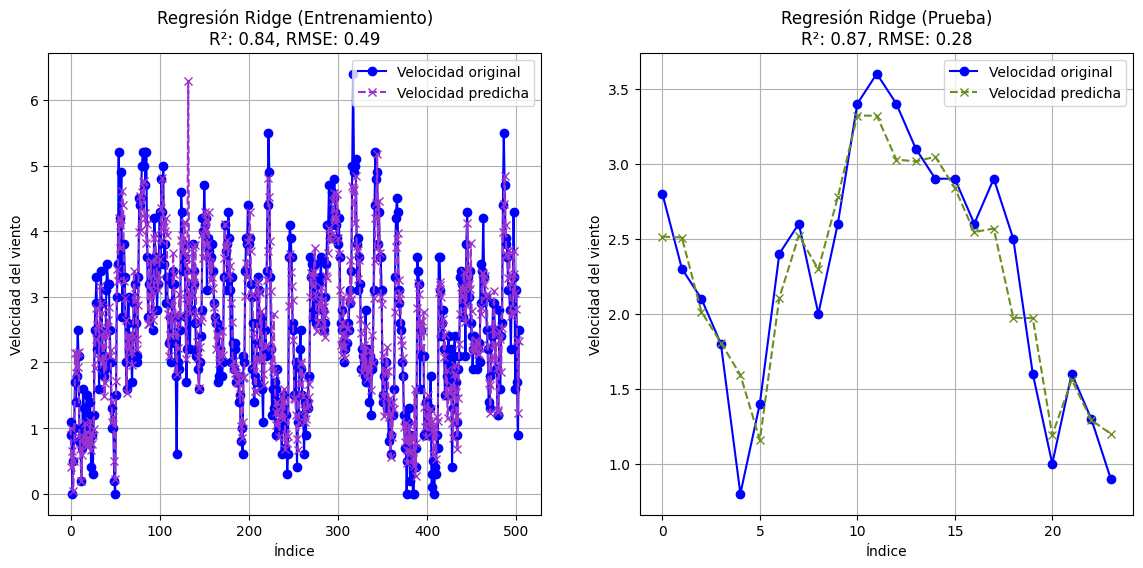

In [98]:
grafica(mejores[2][0], mejores[2][1], mejores[2][2], mejores[2][3], mejores[2][4]).show()

En la gráfica de la **Regresión Ridge** se observan los resultados para el conjunto de entrenamiento y el de prueba. En el conjunto de **entrenamiento**, el modelo presenta un **R² de 0.78** y un **RMSE de 0.62**, lo que indica un ajuste aceptable pero con un error algo elevado. Las predicciones siguen la tendencia de los datos originales, aunque con bastante ruido. En el conjunto de **prueba**, el desempeño mejora con un **R² de 0.81** y un **RMSE de 0.31**, lo que sugiere que el modelo generaliza bien, con predicciones mucho más precisas y alineadas con los valores reales. En conclusión, el modelo tiene mejor capacidad de predicción en los datos de prueba que en los de entrenamiento, lo que indica una buena generalización.